In [3]:
import onnx
import onnxruntime as ort
import numpy as np

In [48]:
onnx_model_path = "hair_classifier_v1.onnx"
onnx_model = onnx.load(onnx_model_path)
# Create an inference session
session = ort.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])
inputs = session.get_inputs()
outputs = session.get_outputs()


print("Model Inputs:")
for input_meta in inputs:
    print(f"  Name: {input_meta.name}")
    print(f"  Shape: {input_meta.shape}")
    print(f"  Data Type: {input_meta.type}")

print("\nModel Outputs:")
for output_meta in outputs:
    print(f"  Name: {output_meta.name}")
    print(f"  Shape: {output_meta.shape}")
    print(f"  Data Type: {output_meta.type}")


input_name = inputs[0].name
output_name = outputs[0].name

print(f'\nInputs: {input_name}')
print(f'Outputs: {output_name}')

Model Inputs:
  Name: input
  Shape: ['s77', 3, 200, 200]
  Data Type: tensor(float)

Model Outputs:
  Name: output
  Shape: ['s77', 1]
  Data Type: tensor(float)

Inputs: input
Outputs: output


## Preparing the Image

In [49]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

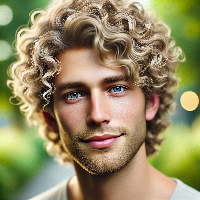

In [50]:
url = 'https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg'
target_size = (200, 200)
img = download_image(url)
img = prepare_image(img, target_size)
img

In [67]:
## Question 3, Turn the image into numpy array and preprocess it
def preprocess_pytorch_style(X):
    X = X / 255.0 # convert to tensor, value between 0 and 1

    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

    # convert (batch, height, width, channels) to (batch, channels, height, width)
    X = X.transpose(0, 3, 1, 2)
    # Normalize
    X = (X - mean) / std
    return X.astype(np.float32)

In [68]:
X = np.array(img)
X = np.expand_dims(X, axis=0)
print(f"X Shape After batch dim added: {X.shape}")  # (1, 200, 200, 3)

X = preprocess_pytorch_style(X)
print(f"X Shape After preprocessing: {X.shape}") 

X Shape After batch dim added: (1, 200, 200, 3)
X Shape After preprocessing: (1, 3, 200, 200)


In [69]:
X[0][0][0][0] # value of R in the first pixel

np.float32(-1.0732939)

In [70]:
X

array([[[[-1.0732939 , -1.004795  , -1.0390444 , ..., -1.0732939 ,
          -1.0732939 , -1.210292  ],
         [-1.0561692 , -1.0219197 , -1.004795  , ..., -1.0219197 ,
          -1.0561692 , -1.1760424 ],
         [-0.9534207 , -0.9705454 , -0.91917115, ..., -1.0219197 ,
          -1.1075435 , -1.2274168 ],
         ...,
         [-1.6726604 , -1.6726604 , -1.5185375 , ...,  1.7351657 ,
           1.6495419 ,  1.7865399 ],
         [-1.6726604 , -1.6555356 , -1.6384108 , ...,  1.6837914 ,
           1.5981677 ,  1.7009162 ],
         [-1.6384108 , -1.7240345 , -1.6726604 , ...,  1.718041  ,
           1.7351657 ,  1.6837914 ]],

        [[-0.214986  , -0.10994398, -0.10994398, ..., -0.5126051 ,
          -0.47759104, -0.63515407],
         [-0.197479  , -0.16246499, -0.16246499, ..., -0.5126051 ,
          -0.54761904, -0.60014004],
         [-0.07492997, -0.12745099, -0.14495799, ..., -0.47759104,
          -0.60014004, -0.7051821 ],
         ...,
         [-1.1428572 , -1.1428572 

In [71]:
type(X[0][0][0][0])

numpy.float32

In [72]:
result = session.run([output_name], {input_name: X})
result

[array([[0.09156593]], dtype=float32)]

In [76]:
predictions = result[0][0].tolist()
predictions[0]

0.09156592935323715